#### 离散栅格数据

本节介绍几个新的数据集：

1. The Cropland Data Layer (CDL)：美国农业部提供的农田数据（每年的玉米、小麦等等的种植），栅格数据。

该栅格数据包含2010和2020的农业情况，分别是两个tif数据

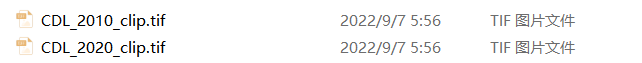

2. The National Hydrography Dataset (NHD) 美国的水文数据（这是一个矢量数据）

包含 ：流线、分水岭边界和子分水岭边界，三个shp文件
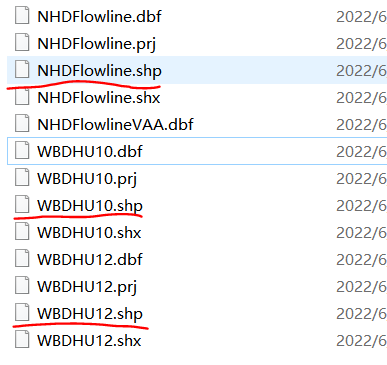

这两个数据分别在 CropScapeR 和 nhR 这两个函数库中可以取到，

我本地也有这个数据，方便大家认识两种数据库

#### 下面，首先载入函数库

In [3]:
library(tidyverse)
library(sf)
library(terra)
library(scales)
library(colorspace)
library(ggspatial) # 处理栅格数据
f_dir <- "C:/Users/77387/Desktop/Data_analysis_courses/R语言与地理信息处理/Chapter10/"
source(paste(f_dir,"rasterdf.R",sep="")) # 辅助画图的函数，github上会提供


In [4]:
paste(f_dir,"rasterdf.R",sep="")

[1] "C:/Users/77387/Desktop/Data_analysis_courses/R语言与地理信息处理/Chapter10/rasterdf.R"

In [5]:

crop2010 <- rast(paste(f_dir,"CDL_2010_clip.tif",sep=""))
crop2020 <- rast(paste(f_dir,"CDL_2020_clip.tif",sep=""))
streams <- st_read(paste(f_dir,"NHDFlowline.shp",sep=""), quiet = TRUE)
wsheds <- st_read(paste(f_dir,"WBDHU10.shp",sep=""), quiet = TRUE)
subwsh <- st_read(paste(f_dir,"WBDHU12.shp",sep=""), quiet = TRUE)

两数据集合并之前，需要检查两数据集的坐标参考系（coordinate reference systems）

In [10]:
writeLines(st_crs(wsheds)$WktPretty)

GEOGCS["NAD83",
    DATUM["North_American_Datum_1983",
        SPHEROID["GRS 1980",6378137,298.257222101]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433,
        AUTHORITY["EPSG","9122"]],
    AXIS["Latitude",NORTH],
    AXIS["Longitude",EAST],
    AUTHORITY["EPSG","4269"]]


CDL 数据是根据 Albers Equal Area coordinate system 投影

In [11]:
writeLines(st_crs(crop2010)$WktPretty)

PROJCS["unnamed",
    GEOGCS["NAD83",
        DATUM["North_American_Datum_1983",
            SPHEROID["GRS 1980",6378137,298.257222101004]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4269"]],
    PROJECTION["Albers_Conic_Equal_Area"],
    PARAMETER["latitude_of_center",23],
    PARAMETER["longitude_of_center",-96],
    PARAMETER["standard_parallel_1",29.5],
    PARAMETER["standard_parallel_2",45.5],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH]]


由于第8章中讨论的原因，所有三个矢量数据集都被重新投影以匹配栅格数据的坐标系，而不是重新投影栅格数据。

In [13]:
wsheds_aea <- st_transform(wsheds, crs(crop2010))
subwsh_aea <- st_transform(subwsh, crs(crop2010))
streams_aea <- st_transform(streams, crs(crop2010))

### 可视化和整理矢量数据

Warning message:
"st_point_on_surface assumes attributes are constant over geometries"


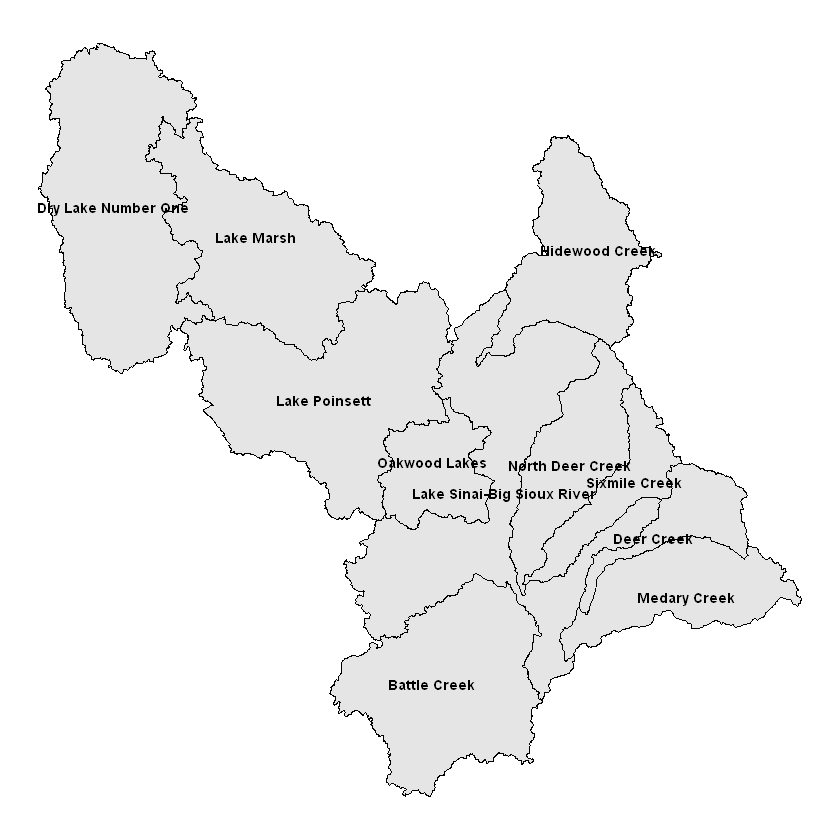

In [14]:
wsheds_aea <- cbind(wsheds_aea, 
                    st_coordinates(st_point_on_surface(wsheds_aea)))

ggplot(data = wsheds_aea) +
  geom_sf(color = "black", 
          size = 0.1) +
  geom_text(aes(x = X, 
                y = Y, 
                label = name),
            size = 3, 
            fontface = "bold") +
  coord_sf() +
  theme_void()

In [15]:
wsheds$name

[1] "Lake Sinai-Big Sioux River" "Deer Creek"                
 [3] "Medary Creek"               "Dry Lake Number One"       
 [5] "Lake Marsh"                 "Lake Poinsett"             
 [7] "Hidewood Creek"             "Oakwood Lakes"             
 [9] "Sixmile Creek"              "North Deer Creek"          
[11] "Battle Creek"

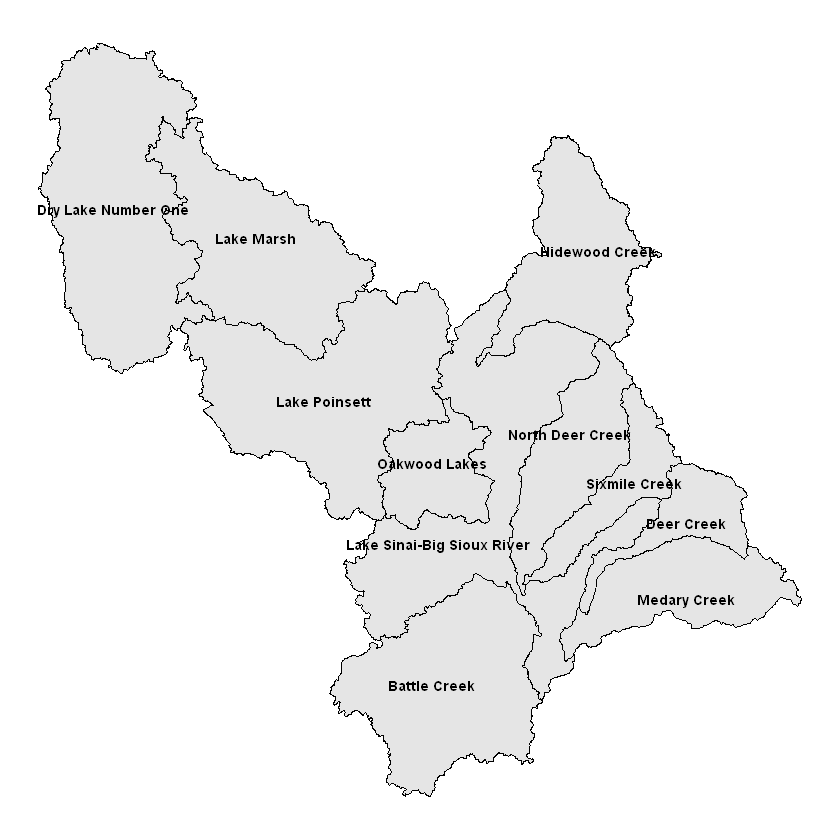

In [16]:
hnudge <- c(-10000, 5000, 0, 0, 0, 0, 0, 0, 0, 0, 0)
vnudge <- c(-7500, 2500, 0, 0, 0, 0, 0, 0, 0, 5000, 0)

ggplot(data = wsheds_aea) +
  geom_sf(color = "black",
          size = 0.1) +
  geom_text(aes(x = X,
                y = Y, 
                label = name),
            nudge_x = hnudge,
            nudge_y = vnudge,
            size = 3, 
            fontface = "bold") +
  theme_void()

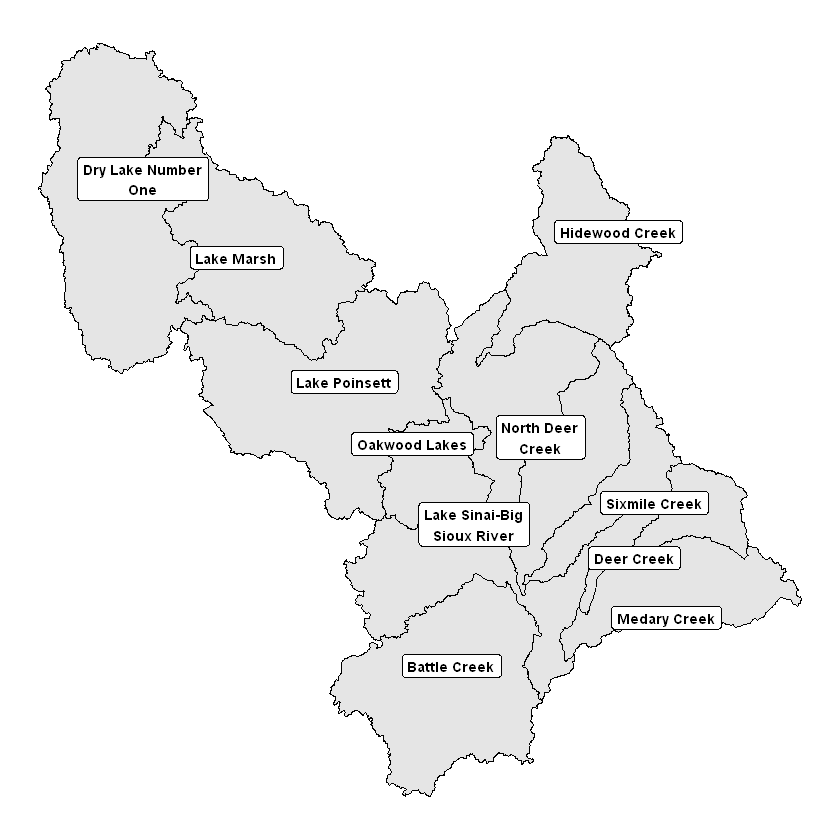

In [17]:
ggplot(data = wsheds_aea) +
  geom_sf(color = "black",
          size = 0.1) +
  geom_spatial_label_repel(aes(x = X,
                               y = Y, 
                               label = str_wrap(name, 15)),
                           size = 3, 
                           fontface = "bold",
                           crs = st_crs(wsheds_aea)) +
  theme_void()

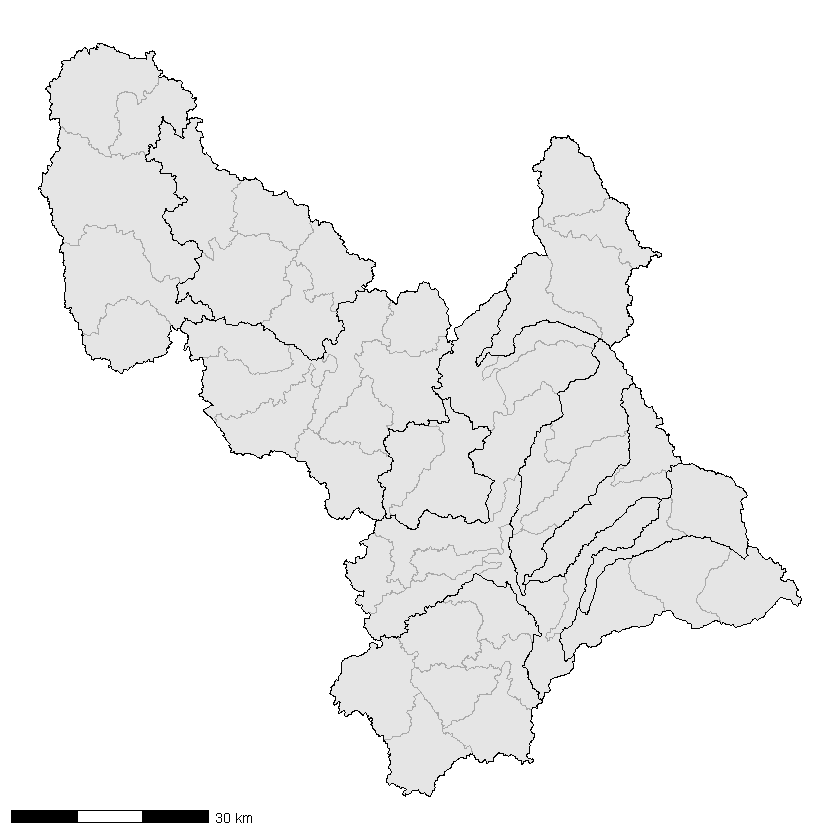

In [18]:
ggplot() +
  geom_sf(data = subwsh_aea, color = "darkgray") +
  geom_sf(data = wsheds_aea, color = "black", fill = NA) +
  annotation_scale(location = 'bl') +
  theme_void()

接下来的分析将聚焦于北鹿溪流域，提取该流域的边界

In [21]:
wshed_ndc <- wsheds_aea %>%
  filter(name == "North Deer Creek")

In [23]:
subwsh_ndc <- subwsh_aea %>%
  filter(lengths(st_covered_by(., wshed_ndc)) > 0)

### 离散栅格数据

合并两个离散栅格数据

In [24]:
cdlstack <- c(crop2010, crop2020)
names(cdlstack) <- c("2010", "2020")

cdl_crop <- crop(cdlstack, vect(subwsh_ndc))
subwsh_msk <- rasterize(vect(subwsh_ndc), cdl_crop)
cdl_mbs <- mask(cdl_crop, subwsh_msk)

重新对不同的农作物类别赋值

In [25]:
oldclas <- c(1, 5, 37, 176, 195)
newclas <- c(1, 2, 3, 3, 3)
lookup <- data.frame(oldclas, newclas)
cdl_rc <- classify(cdl_mbs, 
                       rcl = lookup,
                       others = 4)

Warning message:
"Removed 928876 rows containing missing values (`geom_raster()`)."


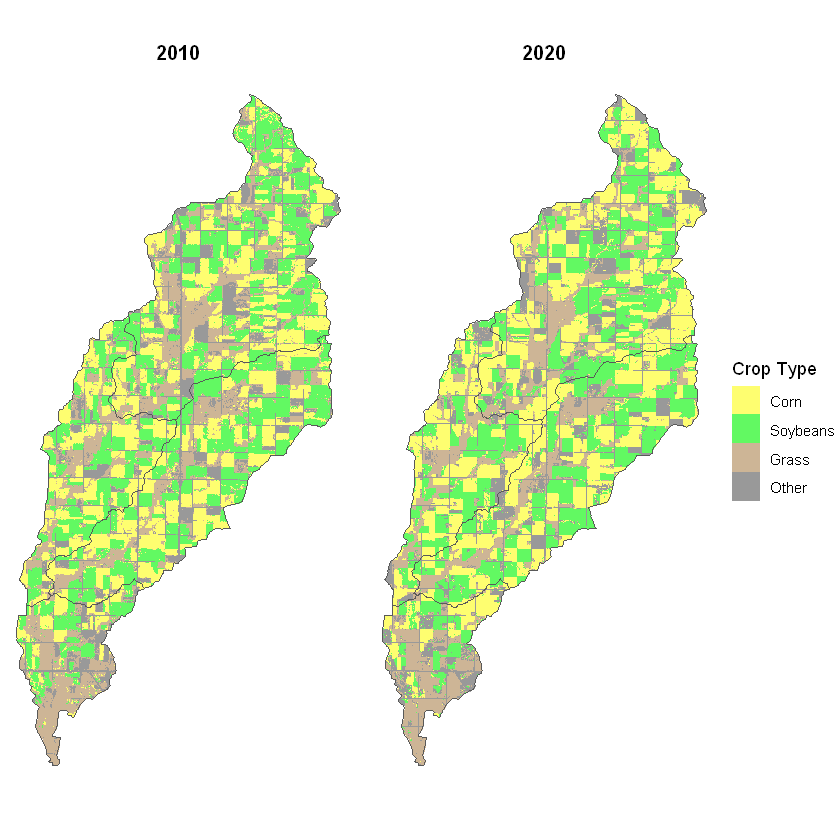

In [26]:
newnames <- c("Corn",
              "Soybeans",
              "Grass",
              "Other")
newcols <- c("yellow", 
             "green", 
             "tan", 
             "gray60")
newcols2 <- desaturate(newcols, 
                       amount = 0.2)
cdl_df <- rasterdf(cdl_rc)

ggplot(data = cdl_df) +
  geom_raster(aes(x = x, 
                  y = y, 
                  fill = 
                    as.character(value))) + 
  scale_fill_manual(name = "Crop Type",
                    values = newcols2,
                    labels = newnames,
                    na.translate = FALSE) +
  geom_sf(data = subwsh_ndc,
          fill = NA) +
  facet_wrap(facets = vars(variable), ncol = 2) +
  theme_void() +
  theme(strip.text.x = element_text(size=12, face="bold"))

In [28]:
subwsh_r <- rasterize(vect(subwsh_ndc), 
                      cdl_rc, 
                      field = "ObjectID")
cdlsum10 <- crosstab(c(subwsh_r, cdl_rc[["2010"]]))
cdlsum10 <- as_tibble(cdlsum10)
cdlsum20 <- crosstab(c(subwsh_r, cdl_rc[["2020"]]))
cdlsum20 <- as_tibble(cdlsum20)

In [29]:
cdljoin <- cdlsum10 %>%
  inner_join(cdlsum20,
             by = c("ObjectID" = "ObjectID",
                    "X2010" = "X2020")) 

分区计算

In [30]:
cdljoin2 <- cdljoin %>%
  mutate(croptype = factor(X2010,
                           labels = newnames),
         ObjectID = as.numeric(ObjectID)) %>%
  select(-X2010) %>%
  rename("cnt2010" = "n.x",
         "cnt2020" = "n.y")
cdljoin2

ObjectID,cnt2010,cnt2020,croptype
<dbl>,<int>,<int>,<fct>
38,42810,53551,Corn
39,22745,26070,Corn
40,35535,37192,Corn
41,6603,8636,Corn
38,48192,43019,Soybeans
39,22238,19146,Soybeans
40,40287,41062,Soybeans
41,8704,6928,Soybeans
38,32396,25490,Grass


In [31]:
cdlpivot <- cdljoin2 %>%
  pivot_longer(cols = starts_with("cnt"),
               names_to = "year",
               values_to = "cnt") %>%
  mutate(year = parse_number(year)) 
cdlpivot

ObjectID,croptype,year,cnt
<dbl>,<fct>,<dbl>,<int>
38,Corn,2010,42810
38,Corn,2020,53551
39,Corn,2010,22745
39,Corn,2020,26070
40,Corn,2010,35535
40,Corn,2020,37192
41,Corn,2010,6603
41,Corn,2020,8636
38,Soybeans,2010,48192


In [32]:
cdlperc <- cdlpivot %>%
  group_by(ObjectID, year) %>%
  mutate(tot = sum(cnt),
         perc_crop = 100 * cnt / tot)
cdlperc

ObjectID,croptype,year,cnt,tot,perc_crop
<dbl>,<fct>,<dbl>,<int>,<int>,<dbl>
38,Corn,2010,42810,145244,29.47454
38,Corn,2020,53551,145244,36.86968
39,Corn,2010,22745,65739,34.59894
39,Corn,2020,26070,65739,39.65682
40,Corn,2010,35535,108985,32.60540
40,Corn,2020,37192,108985,34.12580
41,Corn,2010,6603,40354,16.36269
41,Corn,2020,8636,40354,21.40060
38,Soybeans,2010,48192,145244,33.18003


In [33]:
cdlperc <- cdlsum10 %>%
  inner_join(cdlsum20,
             by = c("ObjectID" = "ObjectID",
                    "X2010" = "X2020")) %>%
  mutate(croptype = factor(X2010,
                           labels = newnames),
         ObjectID = as.numeric(ObjectID)) %>%
  rename("cnt2010" = "n.x",
         "cnt2020" = "n.y") %>%
  pivot_longer(cols = starts_with("cnt"),
               names_to = "year",
               values_to = "cnt") %>%
  mutate(year = parse_number(year)) %>%
  group_by(ObjectID, year) %>%
  mutate(tot = sum(cnt),
         perc_crop = 100 * cnt / tot)

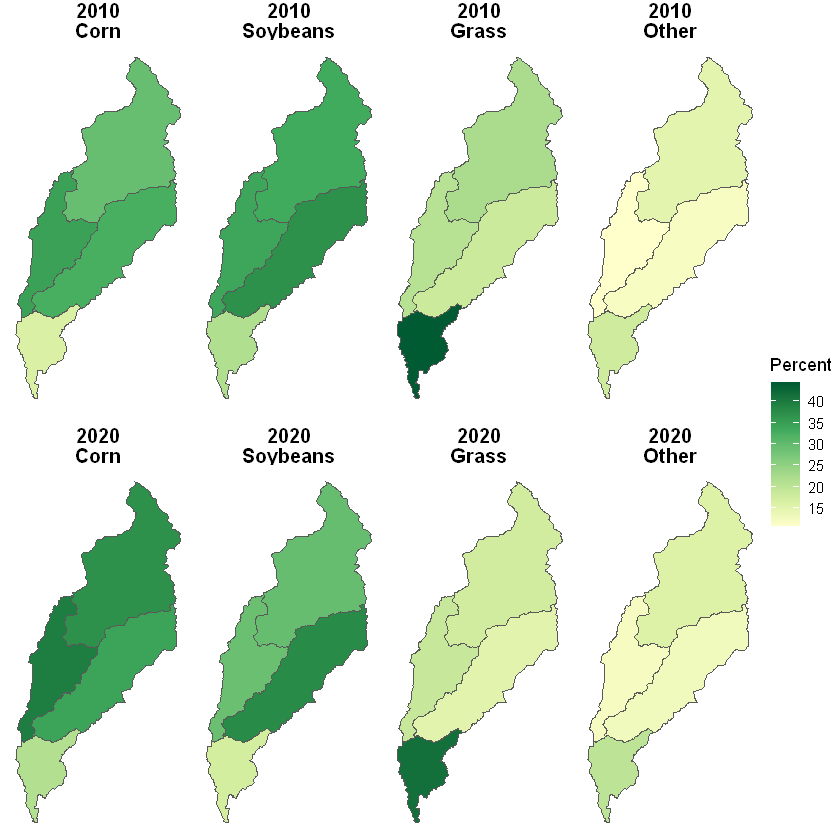

In [34]:
subwsh_perc <- left_join(subwsh_ndc, 
                         cdlperc, 
                         by = "ObjectID")

ggplot(data = subwsh_perc) +
  geom_sf(aes(fill = perc_crop)) +
  scale_fill_distiller(name="Percent", 
                       palette = "YlGn", 
                       breaks = pretty_breaks(),
                       direction = 1) +
  facet_wrap(year ~ croptype, 
             ncol = 4) +
  theme_void() +
  theme(strip.text.x = element_text(size=12, face="bold"))

## 河流覆盖

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


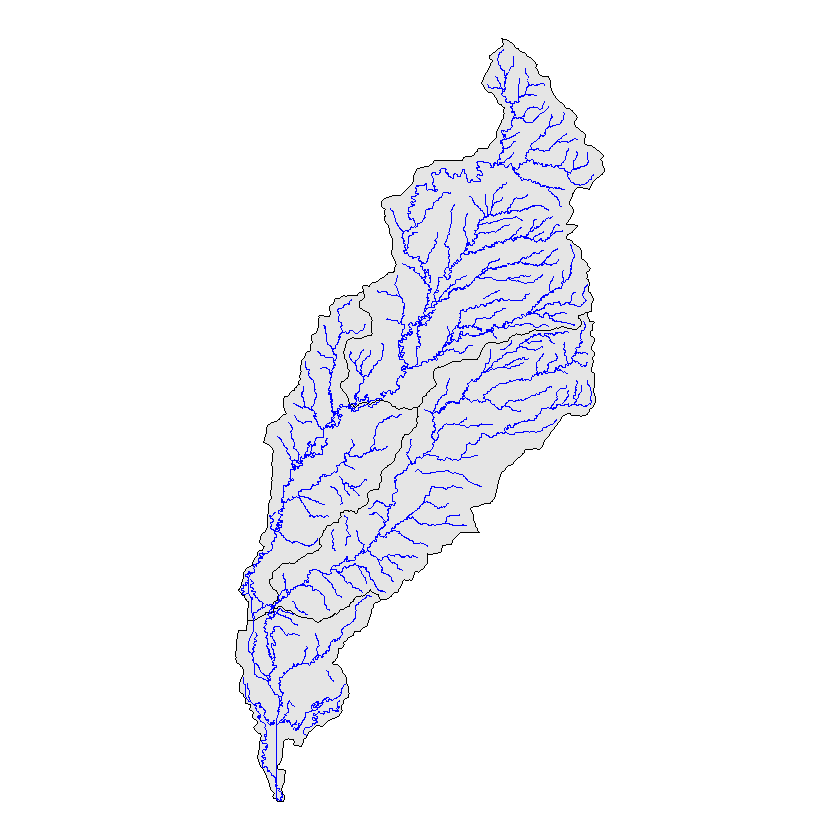

In [35]:
streams_aea <- st_zm(streams_aea)
streams_ndc <- st_intersection(streams_aea, wshed_ndc)

ggplot() +
  geom_sf(data = subwsh_ndc, 
          color = "black", 
          size = 1) +
  geom_sf(data = streams_ndc, 
          color = "blue") +
  theme_void()

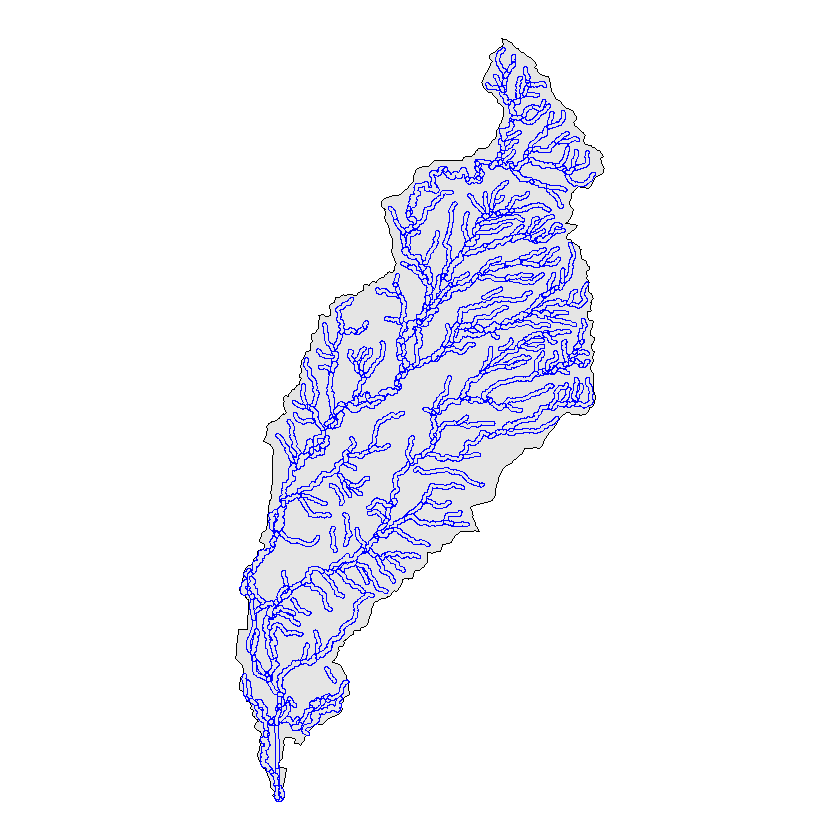

In [36]:
streams_buff <- st_buffer(streams_ndc, dist = 100)

ggplot() +
  geom_sf(data = wshed_ndc, 
          color = "black", 
          size = 1) +
  geom_sf(data = streams_buff, 
          color = "blue") +
  theme_void()

In [37]:
streams_comb <- st_union(streams_buff)
class(streams_comb)
streams_comb <- st_sf(streams_comb)
class(streams_comb)

[1] "sfc_MULTIPOLYGON" "sfc"

[1] "sf"         "data.frame"

In [38]:
riparian <- st_intersection(streams_comb, wshed_ndc)
upland <- st_difference(wshed_ndc, streams_comb)

Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"
Warning message:
"attribute variables are assumed to be spatially constant throughout all geometries"


Warning message:
"Removed 928876 rows containing missing values (`geom_raster()`)."


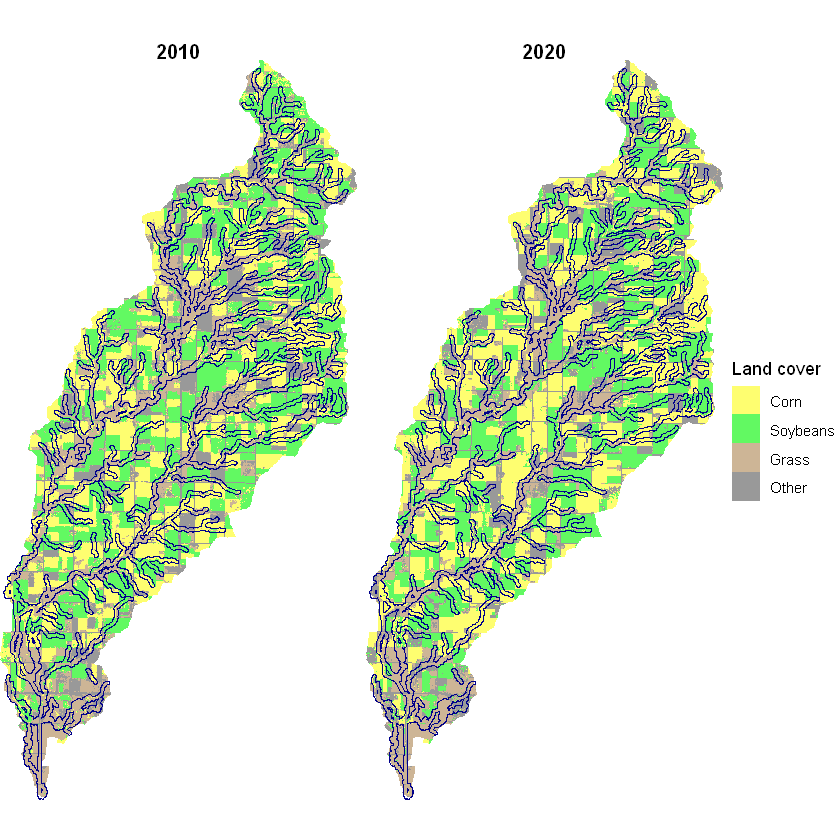

In [39]:
ggplot(data = cdl_df) + 
  geom_raster(aes(x = x, 
                  y = y, 
                  fill = as.character(value))) + 
  scale_fill_manual(name = "Land cover",
                    values = newcols2,
                    labels = newnames,
                    na.translate = FALSE) +
  facet_wrap(facets = vars(variable), ncol = 2) +
  geom_sf(data = streams_comb, 
          color = "darkblue", 
          fill = NA) +
  coord_sf(expand = F) +
  theme_void() +
  theme(strip.text.x = element_text(size=12, face="bold"))

In [40]:
riparian_mask <- rasterize(vect(riparian), cdl_rc)
cdl_rip <- mask(cdl_rc, riparian_mask)
upland_mask <- rasterize(vect(upland), cdl_rc)
cdl_up <- mask(cdl_rc, upland_mask)

In [41]:
freq_rip <- as_tibble(freq(cdl_rip))
freq_rip

layer,value,count
<dbl>,<dbl>,<dbl>
1,1,26599
1,2,26396
1,3,45230
1,4,12117
2,1,29395
2,2,24737
2,3,40868
2,4,15342


In [42]:
freq_up <- as_tibble(freq(cdl_up))
freq_up

layer,value,count
<dbl>,<dbl>,<dbl>
1,1,81094
1,2,93025
1,3,38507
1,4,37354
2,1,96054
2,2,85418
2,3,30321
2,4,38187


In [43]:
cdl_chng <- freq_rip %>%
  bind_rows(freq_up) %>%
  mutate(landtype = c(rep("Riparian", 8), rep("Upland", 8)),
         year = factor(layer,
                       labels = c("2010", "2020")),
         croptype = factor(value,
                           labels = newnames)) %>%
  select(-layer, -value) %>%
  group_by(landtype) %>%
  mutate(totarea = sum(count),
         percarea = 100 * count / totarea)
cdl_chng

count,landtype,year,croptype,totarea,percarea
<dbl>,<chr>,<fct>,<fct>,<dbl>,<dbl>
26599,Riparian,2010,Corn,220684,12.052981
26396,Riparian,2010,Soybeans,220684,11.960994
45230,Riparian,2010,Grass,220684,20.495369
12117,Riparian,2010,Other,220684,5.490656
29395,Riparian,2020,Corn,220684,13.319951
24737,Riparian,2020,Soybeans,220684,11.209240
40868,Riparian,2020,Grass,220684,18.518787
15342,Riparian,2020,Other,220684,6.952022
81094,Upland,2010,Corn,499960,16.220098


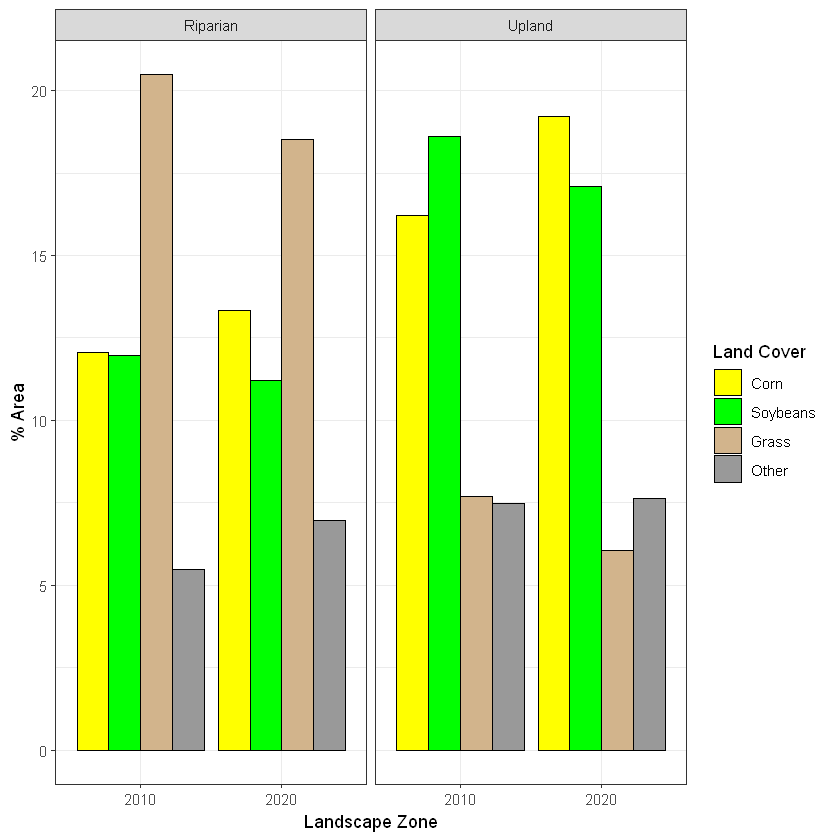

In [44]:
ggplot(data = cdl_chng) +
  geom_bar(aes(y = percarea, 
               x = year, 
               fill = croptype),
           color = "black",
           position = "dodge",
           stat = "identity")  +
  scale_fill_manual(name = "Land Cover", 
                    values = newcols) +
  facet_wrap(facets = vars(landtype), 
             ncol = 2) +
  labs(x = "Landscape Zone", 
       y = "% Area") +
  theme_bw()

## Summarizing Land Cover With Point Buffers

In [45]:
set.seed(32145)
plots <- st_sample(wshed_ndc, size = 20)
class(plots)


plots <- st_as_sf(plots)
class(plots)

[1] "sfc_POINT" "sfc"

[1] "sf"         "data.frame"

Warning message:
"Removed 928876 rows containing missing values (`geom_raster()`)."


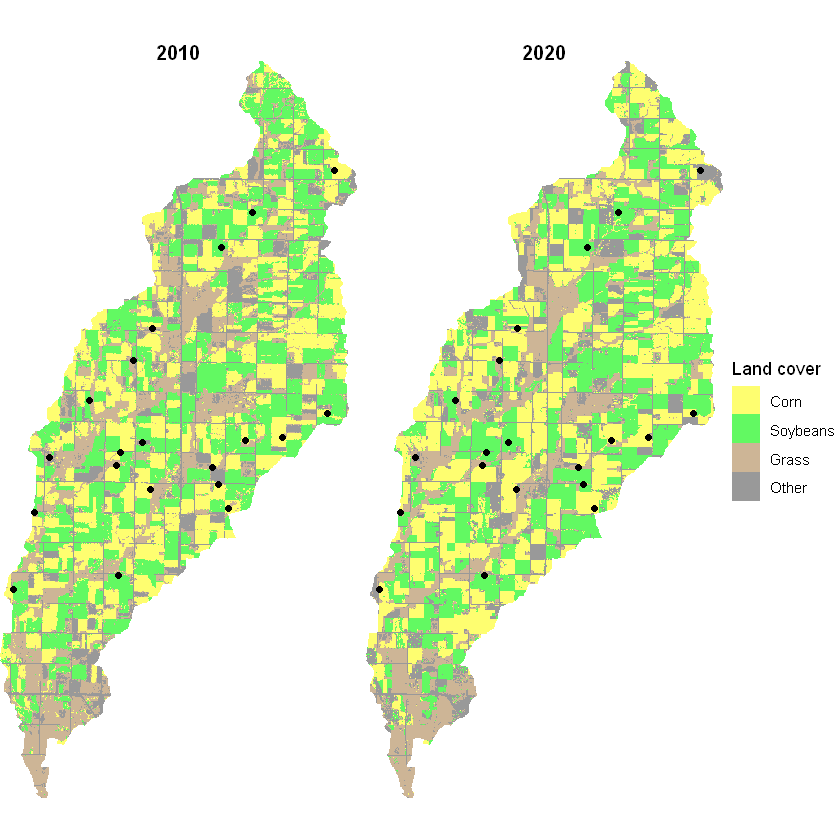

In [46]:
ggplot(data = cdl_df) + 
  geom_raster(aes(x = x, y = y, fill = as.character(value))) + 
  scale_fill_manual(name = "Land cover",
                    values = newcols2,
                    labels = newnames,
                    na.translate = FALSE) +
  geom_sf(data = plots, fill = NA) +
  facet_wrap(facets = vars(variable)) +
  coord_sf(expand = F) +
  theme_void() +
  theme(strip.text.x = element_text(size=12, face="bold"))

In [47]:
st_geometry_type(plots, by_geometry = FALSE)

plot_poly <- st_buffer(plots, dist = 200)
st_geometry_type(plot_poly, by_geometry = FALSE)

[1] POINT
18 Levels: GEOMETRY POINT LINESTRING POLYGON MULTIPOINT ... TRIANGLE

[1] POLYGON
18 Levels: GEOMETRY POINT LINESTRING POLYGON MULTIPOINT ... TRIANGLE

In [48]:
cdl_stk <- segregate(cdl_rc[["2020"]])
names(cdl_stk) <- newnames

plots_cdl <- extract(cdl_stk,
                    vect(plot_poly ), 
                    fun = mean, 
                    na.rm = T)

In [49]:
plots_long <- plots_cdl %>%
  pivot_longer(Corn:Other, 
               names_to = "croptype", 
               values_to = "percarea")
plots_long

ID,croptype,percarea
<int>,<chr>,<dbl>
1,Corn,1.00000000
1,Soybeans,0.00000000
1,Grass,0.00000000
1,Other,0.00000000
2,Corn,0.00000000
2,Soybeans,1.00000000
2,Grass,0.00000000
2,Other,0.00000000
3,Corn,0.58273381


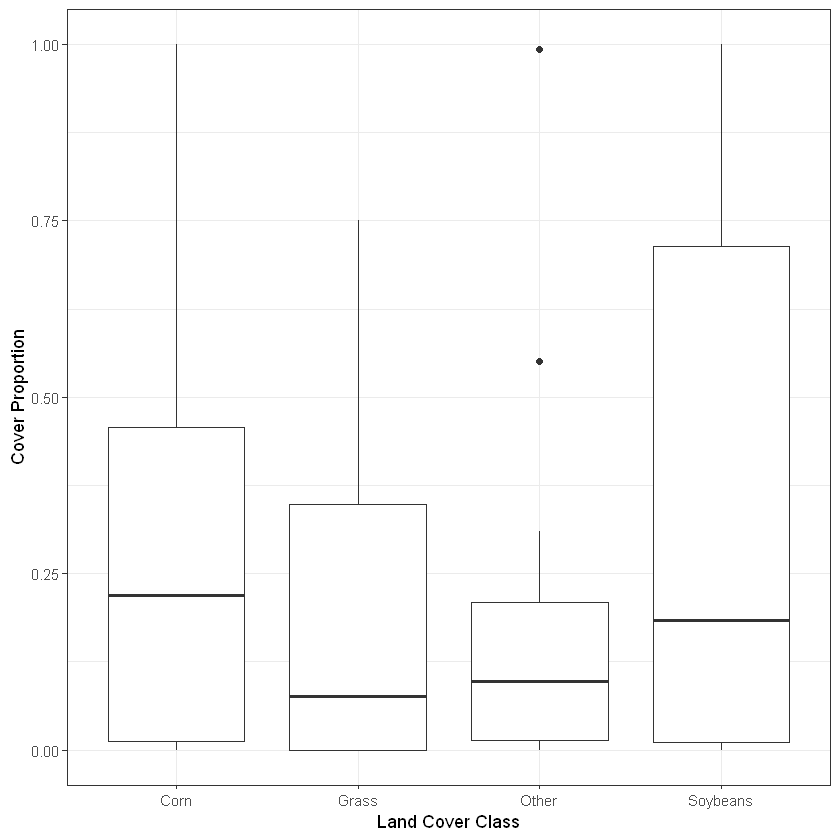

In [50]:
ggplot(data = plots_long) +
  geom_boxplot(aes(x = croptype, 
                   y = percarea)) +
  xlab("Land Cover Class") +
  ylab("Cover Proportion") +
  theme_bw()